In [102]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsai.all import *
import torch.optim as optim


In [103]:
torch.cuda.set_device(2) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [104]:
# load data
file = "physionet.org/files/adfecgdb/1.0.0/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/amirsalimi/ECG_Nexting/physionet.org/files/adfecgdb/1.0.0/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [107]:
# important variables
PRED_LENGTH = 200 # how many samples in the future are we predicting
WINDOW_LENGTH = 2000 # how many samples we look to make predictions
TOTAL_LENGTH = PRED_LENGTH + WINDOW_LENGTH

SLIDE_SIZE = 1
INPUT_DIM = 5
OUTPUT_DIM = 5

<AxesSubplot:>

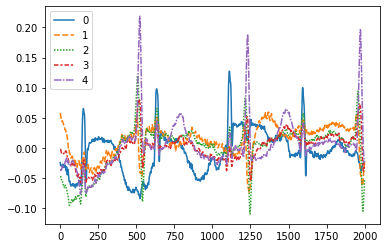

In [108]:
from sklearn.preprocessing import normalize
import seaborn as sns
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# raw_data = raw_data.astype("float32")
sns.lineplot(data = raw_data[:,0:WINDOW_LENGTH].T)

Dataloader

In [109]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, d,WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE):
        'Initialization'
        self.data = d
        self.step_size = SLIDE_SIZE
        self.window_length = WINDOW_LENGTH
        self.pred_length = PRED_LENGTH
        self.num_windows = (d.shape[-1]-self.window_length-self.pred_length)//self.step_size
        print(self.num_windows,self.window_length,d.shape[-1])
    def __len__(self):
        'Denotes the total number of samples'
        return self.num_windows

    def __getitem__(self, index):
        'Generates one sample of data'
        n = index 
        X = self.data[:,n:n+self.window_length]
        y = self.data[:,n+self.window_length:n+self.window_length+self.pred_length]

        return X, y

In [308]:
sample_size = raw_data.shape[-1]
test_length = sample_size // 5

training_set = Dataset(raw_data[:,0:test_length*4],WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE)
training_generator = torch.utils.data.DataLoader(training_set,batch_size=256)

testing_set = Dataset(raw_data[:,test_length*4:],WINDOW_LENGTH,PRED_LENGTH,SLIDE_SIZE,)
testing_generator = torch.utils.data.DataLoader(testing_set,batch_size=256)

237800 2000 240000
57800 2000 60000


(2200, 5)


<AxesSubplot:>

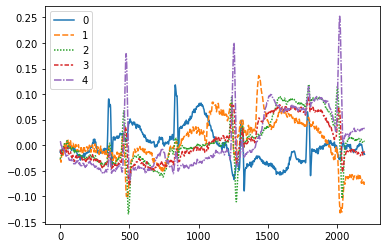

In [309]:
# sanity check for data generator
xt, yt = testing_set[20000][0],testing_set[20000][1]
w = np.concatenate([xt.T,yt.T],axis=0)
print(w.shape)
sns.lineplot(data = w)

In [320]:


model = build_ts_model(InceptionTimePlus, c_in=INPUT_DIM, c_out = PRED_LENGTH, seq_len = WINDOW_LENGTH, d = OUTPUT_DIM)
model = model.to(device)

xt = torch.tensor(xt).float().to(device)
o = model(torch.unsqueeze(xt,dim=0))
o.shape

torch.Size([1, 5, 200])

Define optimizer and loss

In [322]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [323]:
x,y = training_set[0]
x.shape,y.shape

((5, 2000), (5, 200))

In [ ]:

best_val_loss = 1000

for epoch in range(1000):
    running_loss = 0
    for X, y in training_generator:
        X, y = X.to(device).float(),y.to(device).float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    with torch.set_grad_enabled(False):
        validation_loss = 0
        for X, y in testing_generator:
            X, y = X.to(device).float(),y.to(device).float()
            outputs = model(X)
            loss = criterion(outputs, y)
            validation_loss += loss.item()
            scheduler.step(validation_loss)
        if best_val_loss*0.99>validation_loss and epoch>200:
#             torch.save(model.state_dict(), "models/%s.ckpts"%validation_loss)
            best_val_loss = validation_loss
                
    print(f'[{epoch + 1}] train loss: {running_loss:.10f} val loss: {validation_loss:.10f}')

[1] train loss: 12450.4794241413 val loss: 229.1126763523
[2] train loss: 1662.9361329004 val loss: 218.1458825171


In [ ]:
# # overfitting test
# best_val_loss = 1000

# X,y = next(iter(training_generator))
# for epoch in range(10000):

#     X, y = X.to(device).float(),y.to(device).float()
#     # zero the parameter gradients
#     optimizer.zero_grad()
#     # forward + backward + optimize
#     outputs = model(X)
#     loss = criterion(outputs, y)
#     loss.backward()
#     optimizer.step()
#     print(loss.item())
            

visualize a prediction chain 

In [315]:
X,y = next(iter(training_generator))

X.shape,y.shape,outputs.shape

(torch.Size([256, 5, 2000]),
 torch.Size([256, 5, 200]),
 torch.Size([256, 5, 200]))

In [316]:
outputs = model(X.float().to(device))

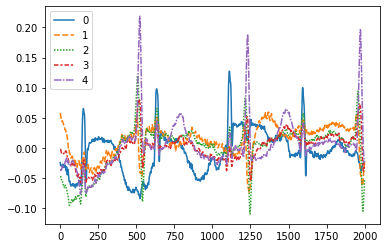

In [317]:
window = X[0].cpu()
sns.lineplot(data = window[:,0:WINDOW_LENGTH].T)
window = torch.tensor(window)

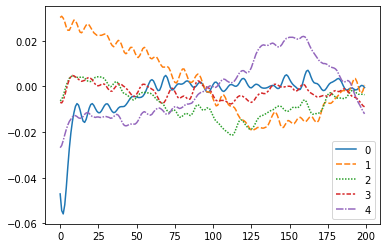

In [318]:
window = y[90].cpu()
sns.lineplot(data = window[:,0:WINDOW_LENGTH].T)
window = torch.tensor(window)

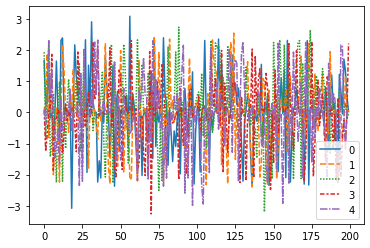

In [319]:
window = outputs[90].detach().cpu()
sns.lineplot(data = window[:,0:WINDOW_LENGTH].T)
window = torch.tensor(window)

In [132]:
loss = nn.MSELoss()
input = pred.cpu()
target = y[0:1].float()
output = loss(input, target)
output

TensorBase(0.0078, grad_fn=<AliasBackward0>)

In [101]:
criterion(outputs,y)

TensorBase(1.8070e-06, device='cuda:2', grad_fn=<AliasBackward0>)